# Summarizing small communities

This notebook reproduces (most of) the analysis in Barnum et. al 2018, which included automatic annotations from HMMs as well as manual annotations. To simplify the programming for other users, this only involves automatic annotation from HMMs. You should have your own HMMs, but an HMM for the conserved gene ribosomal protein S3 (rpS3) is included as a positive control.

In [1]:
# Custom functions and variables
import sys
sys.path.append('./scripts') # Location of modules
from hmmsearch_utils import * 

# Data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(style='ticks',palette='Set2') # Tufte and Brewer style
#sns.despine()
font = {'family' : 'Arial', 'weight' : 'light','size'   : 10,}
plt.rc('font', **font)
plt.rcParams['text.color'] = 'black'
plt.rcParams['svg.fonttype'] = 'none' # Editable SVG text

%matplotlib inline

### Load data (coverage, iRep, names, etc.)

In [2]:
#################

# Define:
data_table = './data/genome-data.csv' # Table with genome data
hmm_directory = './data/hmms/' # Directory with .hmm and .T files (see below)
genome_directory = './data/genomes/' # Directory with .faa file for each genome's proteins
samples = ['Inoculum','1%NaCl','3%NaCl','5%NaCl','7%NaCl'] # Names of each sample

###################

# Each sample should have coverage and irep data for each genome in the below table
# Column names must match the programmatic assignment below
table = pd.read_csv(data_table)
table = table.set_index('MAG ID')
genomes = table.index.tolist()

# Programmatic assignment of irep and cov names
irep_cols = ['irep_' + i for i in samples]
coverage_cols = ['cov_' + i for i in samples] 
# Check columns
for i in irep_cols + coverage_cols:
    if i not in table.columns.tolist():
        print('ERROR: Column %s not present' % i)

table

,MAG,Size (Mbp),Scaffolds (#),Compl. (%),Contam. (%),Strain Var. (%),GC (%),CDS,cov_Sum,cov_Max,cov_1%NaCl,cov_3%NaCl,cov_5%NaCl,cov_7%NaCl,cov_Inoculum,irep_1%NaCl,irep_3%NaCl,irep_5%NaCl,irep_7%NaCl,irep_Inoculum
MAG ID,,,,,,,,,,,,,,,,,,,,
BM001,BM001 Alphaproteobacteria,1.13,10,97.85,0.00,0.00,42.8,1175,27.9,25.0,0.6,0.5,0.7,1.1,25.0,NaN,NaN,NaN,NaN,1.143634
BM002,BM002 Desulfobacteraceae,3.80,638,94.35,3.25,33.33,50.0,3595,10.9,9.4,0.1,0.2,0.4,0.8,9.4,NaN,NaN,NaN,NaN,1.314611
BM003,BM003 Chromatiales,3.62,337,93.35,5.53,25.93,60.6,3404,15.2,6.6,2.1,2.5,2.0,2.0,6.6,NaN,NaN,NaN,NaN,1.375391
BM004,BM004 Desulfobulbaceae,2.66,189,98.13,1.64,25.00,47.5,2487,12.3,6.1,0.9,1.7,1.7,1.9,6.1,NaN,NaN,NaN,NaN,1.392306
BM005,BM005 Desulfobacteraceae,3.05,577,84.52,1.81,0.00,43.3,2788,9.1,5.1,0.5,1.2,1.4,0.9,5.1,NaN,NaN,NaN,NaN,NaN
BM101,BM101 Azoarcus,4.90,160,98.86,3.63,20.00,62.9,4690,514.5,513.8,513.8,0.1,0.2,0.2,0.2,1.294608,NaN,NaN,NaN,NaN
BM102,BM102 Arcobacter,3.48,42,98.78,1.56,0.00,28.1,3530,48.6,48.5,48.5,0.1,0.0,0.0,0.0,1.427262,NaN,NaN,NaN,NaN
BM103,BM103 Desulfuromonas,2.93,426,90.07,6.13,7.69,55.9,2860,8.8,3.6,3.6,2.3,1.8,1.0,0.1,NaN,NaN,NaN,NaN,NaN
BM301,BM301 Sedimenticola,4.26,31,98.72,1.46,0.00,56.4,4076,675.1,674.1,0.2,674.1,0.2,0.3,0.3,NaN,NaN,NaN,NaN,NaN


### Functional annotation with custom HMMs

In [3]:
# Presence and absence of genes, based on HMMs
hmmdf = hmmsearch_ea_genome(hmm_directory, genome_directory)
hmms = hmmdf.columns.tolist()

# Merge annotation with other genome information
df = pd.merge(table,hmmdf,left_index=True,right_index=True, how='outer')
df = df.sort_values(by='MAG ID',ascending=False)

hmmdf


 Searching 48 genomes with HMMs.... 

HMM 	 Threshold score 	 N genomes
ccld 	 125 	 1
clrA1 	 1500 	 0
clrA2 	 2000 	 1
pcld 	 150 	 9
pcrA1 	 800 	 7
pcrA2 	 1000 	 2
rpS3 	 30 	 44

 Search completed.


,ccld,clrA1,clrA2,pcld,pcrA1,pcrA2,rpS3
Genome,,,,,,,
BM001,0,0,0,0,0,0,1
BM002,0,0,0,0,0,0,1
BM003,0,0,0,0,0,0,1
BM004,0,0,0,0,0,0,1
BM005,0,0,0,0,0,0,1
BM101,1,0,1,1,0,0,1
BM102,0,0,0,1,1,0,1
BM103,0,0,0,0,0,0,0
BM301,0,0,0,1,1,0,1


## Plot summary of community

- Gene presence/absence: heatmap of values either 1 or 0
- Relative abundance: heatmap of genome coverage normalized to total coverage of all genomes
- iRep: heatmap of index of replication, typically ~1 to 3 with missing values (lots) as 0

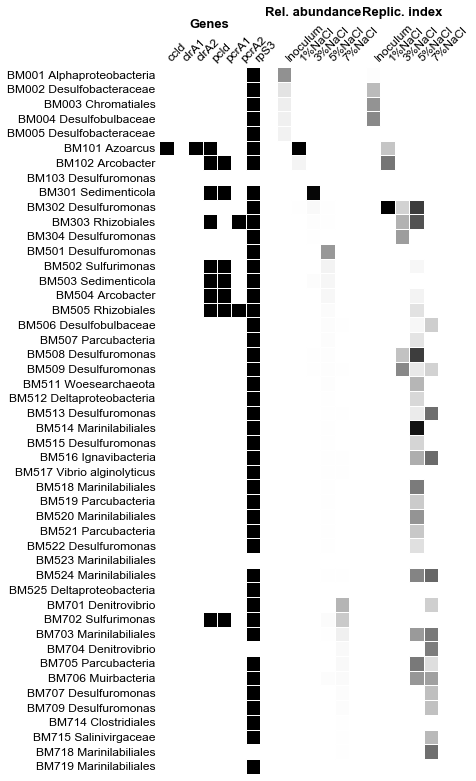

In [4]:
def give_pcolor_ticks(ax, data):
    
    """
    Set tick positions based on data shape
    """
    
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    return


title_format = {'fontweight':'bold', 'fontsize':'13', 'horizontalalignment':'center'}
label_format = {'color':'black', 'fontsize':12}

# Set y order via list of genome IDs
df = df.loc[genomes,:].sort_values(by='MAG',ascending=False)

h_dimensions = [len(hmms),len(coverage_cols),len(irep_cols)]
fig, axes = plt.subplots(1, 3, figsize=(5,13), 
                               gridspec_kw = {'width_ratios':h_dimensions})

# Subplot: Gene presence/absence from hmmsearch
ax=axes[0]
ax.set_title('Genes',**title_format)
data = df.loc[:,hmms]
ax.pcolor(data, cmap='Greys', linewidths=1, edgecolor='white', snap=True)
give_pcolor_ticks(ax, data)
ax.set_yticklabels(df['MAG'].tolist(),**label_format)
ax.set_xticklabels(hmms,**label_format)

# Subplot: Relative abundance (coverage of ea genome / sum coverage of all genomes)
ax=axes[1]
ax.set_title('Rel. abundance',**title_format)
data = df.loc[:,coverage_cols]/df.loc[:,coverage_cols].sum()
ax.pcolor(data,cmap='Greys', linewidths=1, edgecolor='white', snap=True)
give_pcolor_ticks(ax, data)

# Subplot: iRep, index of replication
ax=axes[2]
ax.set_title('Replic. index',**title_format)
data = df.loc[:,irep_cols]
ax.pcolor(data,cmap='Greys', linewidths=1, edgecolor='white', snap=True, facecolor=None)
give_pcolor_ticks(ax, data)
    
for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0) # No tick markers
    ax.set_ylabel(None) # No ylabel
    ax.xaxis.tick_top() # xticklabels on top
    ax.xaxis.set_label_position('top')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,  ha='left') # Rotate x labels
    for position in ['top','bottom','left','right']:
        ax.spines[position].set_visible(False) # Remove border


for ax in axes[1:]:
    ax.set_yticklabels(['']*len(df.index))
    ax.set_xticklabels(samples,**label_format)
    

fig.align_xlabels(axes)
plt.savefig('./data/community-summary.png', bbox_inches="tight") # PNG, not editable
plt.savefig('./data/community-summary.svg', bbox_inches="tight") # SVG, editable in InkScape, etc.
plt.show()

### Bonus: clustering genes by co-occurrence

A particularly useful example for heatmaps is clustering the data so it becomes more interpretable. Here, I cluster genes and genomes by the presence/absence of genes in genomes. Clustering can be directed on both the x and y dimensions, and column order can easily be changed in pandas from the default alphabetical to the new list order.

You may want to select only a subset of relevant genes to cluster.

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

# Cluster data by, for example, HMM presence/absence

# Cluster HMMS and get dendogram leaves (order of HMMs)
data = df.loc[:,hmms].copy()
X = np.array(data.transpose())
Z = linkage(X, method='average')
leaves = leaves_list(Z) 
new_x = [hmms[i] for i in leaves]

# Cluster genomes and get dendogram leaves (order of genomes)
X = np.array(data)
Z = linkage(X, method='average') 
leaves = leaves_list(Z) 
new_y = [genomes[i] for i in leaves]

print('HMMs clustered by HMM presence/absence:')
print(new_x)
print('\n', 'MAGs clustered by HMM presence/absence:')
print(new_y)

HMMs clustered by HMM presence/absence:
['rpS3', 'pcld', 'pcrA1', 'pcrA2', 'clrA1', 'ccld', 'clrA2']

 MAGs clustered by HMM presence/absence:
['BM707', 'BM705', 'BM503', 'BM002', 'BM301', 'BM719', 'BM718', 'BM715', 'BM714', 'BM709', 'BM703', 'BM701', 'BM525', 'BM520', 'BM519', 'BM518', 'BM517', 'BM516', 'BM515', 'BM514', 'BM513', 'BM512', 'BM511', 'BM509', 'BM508', 'BM507', 'BM506', 'BM505', 'BM504', 'BM502', 'BM501', 'BM304', 'BM302', 'BM103', 'BM102', 'BM101', 'BM005', 'BM004', 'BM001', 'BM003', 'BM706', 'BM704', 'BM524', 'BM523', 'BM303', 'BM522', 'BM521', 'BM702']


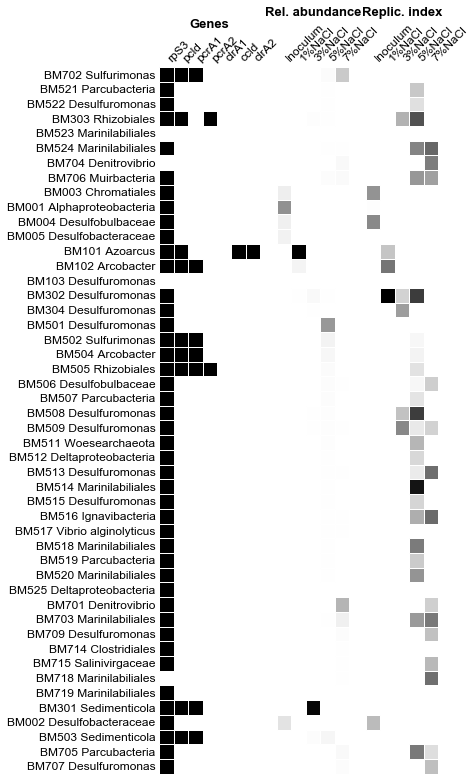

In [6]:
df = df.loc[new_y,:]

h_dimensions = [len(hmms),len(coverage_cols),len(irep_cols)]
fig, axes = plt.subplots(1, 3, figsize=(5,13), 
                               gridspec_kw = {'width_ratios':h_dimensions})

title_format = {'fontweight':'bold', 'fontsize':'13', 'horizontalalignment':'center'}
label_format = {'color':'black', 'fontsize':12}

# Subplot: Gene presence/absence from hmmsearch
ax=axes[0]
ax.set_title('Genes',**title_format)
data = df.loc[:,new_x]
ax.pcolor(data, cmap='Greys', linewidths=1, edgecolor='white', snap=True)
give_pcolor_ticks(ax, data)
ax.set_yticklabels(df['MAG'].tolist(),**label_format)
ax.set_xticklabels(new_x,**label_format)

# Subplot: Relative abundance (coverage of ea genome / sum coverage of all genomes)
ax=axes[1]
ax.set_title('Rel. abundance',**title_format)
data = df.loc[:,coverage_cols]/df.loc[:,coverage_cols].sum()
ax.pcolor(data,cmap='Greys', linewidths=1, edgecolor='white', snap=True)
give_pcolor_ticks(ax, data)

# Subplot: iRep, index of replication
ax=axes[2]
ax.set_title('Replic. index',**title_format)
data = df.loc[:,irep_cols]
ax.pcolor(data,cmap='Greys', linewidths=1, edgecolor='white', snap=True, facecolor=None)
give_pcolor_ticks(ax, data)
    
for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0) # No tick markers
    ax.set_ylabel(None) # No ylabel
    ax.xaxis.tick_top() # xticklabels on top
    ax.xaxis.set_label_position('top')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,  ha='left') # Rotate x labels
    for position in ['top','bottom','left','right']:
        ax.spines[position].set_visible(False) # Remove border


for ax in axes[1:]:
    ax.set_yticklabels(['']*len(df.index))
    ax.set_xticklabels(samples,**label_format)
    

plt.savefig('./data/community-summary-clustered.png', bbox_inches="tight") # PNG, not editable
plt.show()

## Relative abundance grouped by metabolism

It can be valuable to group genomes together based on a shared characteristics such as taxonomic membership or the presence or absence of an important trait. 

Here, I group genomes within each community by respiratory metabolism. I defined metabolism from the presence or absence of genes using boolean statements. Three metabolisms were defined:

- Genomes performing "perchlorate reduction" must have either pcrA1 or pcrA2 and pcld
- Geomees performing "chlorate reduction" must have either clrA1 or clrA2 and pcld
- Genomes performing "other metabolism" do not have pcld

/Users/tylerbarnum/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


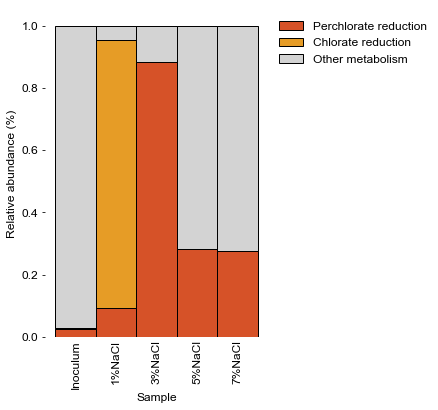

In [7]:
# Assign metabolism using logic statements

### DEFINE METABOLISMS ###
metabolisms = ['Perchlorate reduction','Chlorate reduction','Other metabolism']
colors = ['#D65228','#E69C26','#D3D3D3']
logic_pr = ((df['pcrA1'] == 1) | (df['pcrA2'] == 1)) & (df['pcld'] == 1) 
logic_cr = ((df['clrA1'] == 1) | (df['clrA2'] == 1)) & (df['pcld'] == 1) 
logic_other = (df['pcld'] == 0)

# Sets a value in the rows of the column 'Metabolism' where the boolean is true
df['Metabolism'] = [''] * len(df.index)
df.loc[logic_pr, 'Metabolism'] = metabolisms[0]
df.loc[logic_cr, 'Metabolism'] = metabolisms[1]
df.loc[logic_other, 'Metabolism'] = metabolisms[2]


# Group by metabolism and arrange for plotting
metab = df.groupby('Metabolism').sum()
metab = metab[coverage_cols]
metab = metab / metab.sum() # Normalize for relative abundance
metab = metab.transpose()
metab = metab[metabolisms]

# Plot
fig, ax = plt.subplots(1,1,figsize=(4,6))
metab.plot.bar(ax=ax, stacked=True, width=1,
               fontsize=12,
               colors=colors,  edgecolor='black', linewidth=1)

ax.set_ylabel('Relative abundance (%)',**label_format)
ax.set_xlabel('Sample',**label_format)
ax.set_xticklabels(samples,**label_format)
ax.tick_params(axis='x', which=u'both',length=0) # No tick markers
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=12, frameon=False)

for position in ['top','bottom','left','right']:
        ax.spines[position].set_visible(False) # Remove border

plt.savefig('./data/metabolism-summary.png', bbox_inches="tight")
plt.show()